# <b> Naive Bayes </b>
___

<b> Table of Content: </b>
<br> [Pipeline_1](#800)
<br> [Pipeline 2](#801)
<br> [Pipeline 3](#802)
<br> [Results](#810)

Loading Modules and Datasets

In [80]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix, classification_report 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss 

# Cross Validation packages
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# ROC Curve and AUC
from sklearn.metrics import roc_auc_score

# for plotting
import matplotlib.pyplot as plt
from sklearn.svm import SVC

<a id = "800"> <h2> Pipeline 1 </h2> </a>
___

In [81]:
# read csv file to a pandas dataframe
df_pipeline1 = pd.read_csv("pipeline_1.csv")

> Show all features and target in dataframe

In [82]:
# show all columns in dataset
print('There are', len(df_pipeline1.columns)-1, 'features, and the target `Revenue` for pipeline 1:')
list(df_pipeline1.columns)[:]

There are 22 features, and the target `Revenue` for pipeline 1:


['Q4',
 'VisitorType_New_Visitor',
 'Q3',
 'TrafficType_2',
 'TrafficType_8',
 'TrafficType_3',
 'PageValues_iqr_yj_zscore',
 'Q1',
 'TrafficType_13',
 'ExitRates_iqr_yj_zscore',
 'OperatingSystems_3',
 'Administrative_Duration_iqr_yj_zscore',
 'TrafficType_1',
 'SpecialDay_0.8',
 'Month_Feb',
 'Browser_6',
 'SpecialDay_0.4',
 'TrafficType_20',
 'Informational_Duration_pp_iqr_yj_zscore',
 'Browser_12',
 'OperatingSystems_7',
 'TrafficType_16',
 'Revenue']

In [83]:
print('Number of rows in the dataset:', df_pipeline1.shape[0])
print('Number of columns in the dataset:', df_pipeline1.shape[1])

Number of rows in the dataset: 12330
Number of columns in the dataset: 23


> Declare Features and Target

In [84]:
# Define Features and Target variables
X = df_pipeline1.iloc[:, :-1] # Features is all columns in the dataframe except the last column
Y = df_pipeline1.iloc[:, -1] # Target is the last column in the dataframe: 'Revenue'

<b> Basic Model - imbalanced dataset

In [85]:
# Split dataset into training set and test set 
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=2019) 

# Create a Gaussian Classifier
gnb = GaussianNB()

# Train the model using the training sets
gnb.fit(X_train, y_train)

print('Before OverSampling, the shape of train_X: {}'.format(X_train.shape))  
print("Before OverSampling, counts of label '1' in y_train: {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0' in y_train: {}".format(sum(y_train == 0)))
print('\n')

# given a trained model, predict the label of a new set of data.
y_pred = gnb.predict(X_test)

# print classification report 
print(classification_report(y_test, y_pred))

Before OverSampling, the shape of train_X: (8631, 22)
Before OverSampling, counts of label '1' in y_train: 1340
Before OverSampling, counts of label '0' in y_train: 7291


              precision    recall  f1-score   support

           0       0.96      0.76      0.85      3131
           1       0.38      0.84      0.53       568

    accuracy                           0.77      3699
   macro avg       0.67      0.80      0.69      3699
weighted avg       0.87      0.77      0.80      3699



<b> ROC Curve with AUC score - Basic model </b> (before oversampling/undersampling)

In [99]:
# define a function to plot the roc_curve and AUC score using variables: X_test and y_test
def roc_curve(X_test=X_test, y_test=y_test, model=gnb):
    # set the style of the graph
    plt.style.use('Solarize_Light2')

    # predict_proba gives you the probabilities for the target (0 and 1 in your case) in array form in dimension (N,2). 
    # The first index refers to the probability that the data belong to class 0, and the second refers to the probability that the data belong to class 1. 
    # we define a variable with an array of the probabilities that each observation belongs to class 1 (with [:,1], where model.predict_proba(X_test)[:,0] refers to the array it belongs to class 0)
    y_pred_proba = model.predict_proba(X_test)[:,1]

    # define false positive rate (fpr) and the true positive rate (tpr)
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

    # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    # source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # plot on the X-axis: the false positive rate
    # plot on the Y-axis: the true positive rate
    # with the legend having the auc score
    plt.plot(fpr,tpr,label='AUC = %0.2f' % auc)
    # positioning of the legend
    plt.legend(loc=4)
    # define the title of the plot
    plt.title('Receiver Operating Characteristic (ROC)')
    # define the y axis label
    plt.ylabel('True Positive Rate')
    # define the x axis label
    plt.xlabel('False Positive Rate')
    # plot a straight dashed line in the color red
    plt.plot([0, 1], [0, 1],'r--')
    # show the plot
    plt.show()
    # print out full AUC score
    print('AUC score:', auc)

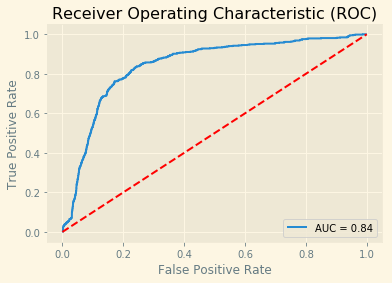

AUC score: 0.8418990467879137


In [100]:
# apply function to plot the ROC Curve
roc_curve(X_test=X_test, y_test=y_test, model=gnb)

<b> 1.1 Synthetic Minority Oversampling Technique (SMOTE)

We oversample the <b> training </b> dataset, because the classes within our target variable 'Revenue' are imbalanced:
* class 0: 84.53%
* class 1: 15.47%

Fore more information, click on detailed information from Prof. Jie Tao [link](https://github.com/DrJieTao/ba545-docs/blob/master/competition2/handling_imbalanced_data_part2.ipynb)

In [101]:
# Split dataset into training set and test set 
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=2019) 

sm = SMOTE(random_state = 2019) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (14582, 22)
After OverSampling, the shape of train_y: (14582,) 

After OverSampling, counts of label '1': 7291
After OverSampling, counts of label '0': 7291


/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The SMOTE Algorithm has oversampled the instances in the minority class and made it equal to majority class:
* Both classes (0 & 1) now have 7291 instances, the <b> training </b> dataset is balanced.
* Class 1 increased from 1340 instances to 7291 instances, an increase of 5951 instances of class 1.

In [102]:
# define the model
gnb1 = GaussianNB()

# train the model
gnb1.fit(X_train_res, y_train_res)

# given a trained model, predict the label of a new set of data. 
y_pred = gnb1.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.49      0.65      3131
           1       0.25      0.93      0.39       568

    accuracy                           0.56      3699
   macro avg       0.61      0.71      0.52      3699
weighted avg       0.86      0.56      0.61      3699



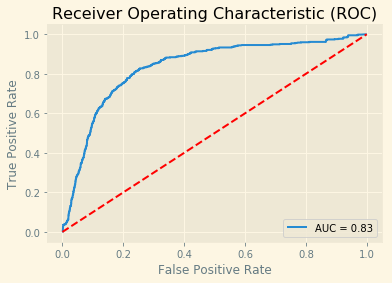

AUC score: 0.8341440771746416


In [106]:
# apply function to plot the ROC Curve
roc_curve(X_test=X_test, y_test=y_test, model=gnb1)

<b> 1.2 NearMiss Under-Sampling Technique </b>
<br> We undersample the dataset, because the classes within our target variable 'Revenue' are imbalanced:
* class 0: 84.53%
* class 1: 15.47%

Fore more information, click on detailed information from Prof. Jie Tao [link](https://github.com/DrJieTao/ba545-docs/blob/master/competition2/handling_imbalanced_data_part2.ipynb)

In [107]:
# apply near miss 
nr = NearMiss(random_state=2019)
  
# resample the training dataset
X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train) 
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape)) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

After Undersampling, the shape of train_X: (2680, 22)
After Undersampling, the shape of train_y: (2680,) 

After Undersampling, counts of label '1': 1340
After Undersampling, counts of label '0': 1340


/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The NearMiss Algorithm has undersampled the instances in the majority class and made it equal to minority class:
* Both classes (0 & 1) now have 1340 instances, the dataset is balanced.
* Class 0 decreased from 7291 instances to 1340 instances, a decrease of 5951 instances of class 0.

In [108]:
# train the model on train set 
gnb2 = GaussianNB()
gnb2.fit(X_train_miss, y_train_miss) 
y_pred = gnb2.predict(X_test) 

# print classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      3131
           1       0.07      0.05      0.06       568

    accuracy                           0.75      3699
   macro avg       0.45      0.47      0.46      3699
weighted avg       0.72      0.75      0.73      3699



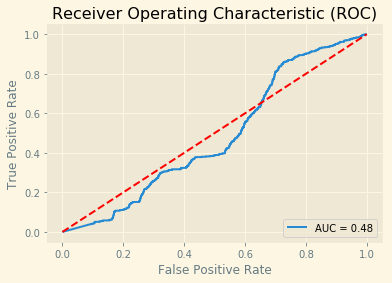

AUC score: 0.48148315797049945


In [109]:
# apply function to plot the ROC Curve
roc_curve(X_test=X_test, y_test=y_test, model=gnb2)

<b> Cross Validation Using KFold </b>
<br> For more information on the topic, please click the following [link](https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/).
<br> The details of the package are noted [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

### Cross Validation (Kfold) applied to the oversampled dataset (with SMOTE)

In [112]:
# Build the k-fold cross-validator
k_fold_split = 10
kfold = KFold(n_splits=k_fold_split, random_state=2019, shuffle=True)
#result = cross_val_score(gnb, X, Y, cv=kfold, scoring='accuracy')
result = cross_val_score(gnb1, X_train_res, y_train_res, cv=kfold, scoring='accuracy')

print('--------------------------------------------------------------------------')
print('All the accuracy results:')
print('--------------------------------------------------------------------------')
print(result, '\n')

print('--------------------------------------------------------------------------')
print('Average of all the accuracy results:')
print('--------------------------------------------------------------------------')
print(round(result.mean(), 4), '\n')

print('--------------------------------------------------------------------------')
print('Conclusion: the average of the accuracy changed after applying Kfold:')
print('--------------------------------------------------------------------------')
print('from:')
print(round(metrics.accuracy_score(y_test, y_pred), 5))
print('to:')
print(round(result.mean(), 5))
print('This is because we only use: {0:0.2f}% of our dataset to train the model!'.format(((k_fold_split-1)/k_fold_split)*100))

--------------------------------------------------------------------------
All the accuracy results:
--------------------------------------------------------------------------
[0.70938999 0.70733379 0.70507545 0.71604938 0.71879287 0.72770919
 0.71673525 0.68587106 0.71673525 0.71193416] 

--------------------------------------------------------------------------
Average of all the accuracy results:
--------------------------------------------------------------------------
0.7116 

--------------------------------------------------------------------------
Conclusion: the average of the accuracy changed after applying Kfold:
--------------------------------------------------------------------------
from:
0.75182
to:
0.71156
This is because we only use: 90.00% of our dataset to train the model!


In [157]:
# Build the k-fold cross-validator
k_fold_split = 10
kfold = KFold(n_splits=k_fold_split, random_state=2019, shuffle=True)
#result = cross_val_score(gnb, X, Y, cv=kfold, scoring='accuracy')
# note: only a single metric is permitted for parameter 'scoring'
# for all parameters for scoring, see source:https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
result_f1_weighted = cross_val_score(gnb1, X_train_res, y_train_res, cv=kfold, scoring='f1_weighted')
print('--------------------------------------------------------------------------')
print('All the weighted f1 results:')
print('--------------------------------------------------------------------------')
print(result_f1_weighted, '\n')

print('--------------------------------------------------------------------------')
print('Average of all the weighted f1 results:')
print('--------------------------------------------------------------------------')
print(round(result_f1_weighted.mean(), 4), '\n')

--------------------------------------------------------------------------
All the weighted f1 results:
--------------------------------------------------------------------------
[0.69228706 0.69037931 0.68784106 0.69829474 0.70433746 0.71252341
 0.70391907 0.66566033 0.70031516 0.69463175] 

--------------------------------------------------------------------------
Average of all the weighted f1 results:
--------------------------------------------------------------------------
0.695 



In [149]:
# source: https://stackoverflow.com/questions/57708023/plotting-the-roc-curve-of-k-fold-cross-validation
# changed the code to a function and made it dynamic for the number of splits, classifier and training set for X, Y

def roc_curve_kfold_cross_validation(X_train=X_train_res, y_train=y_train_res, n_splits=10, classifier=GaussianNB()):
    cv = StratifiedKFold(n_splits=10)
    
    # in the old code the classifier was defined here
    # classifier = SVC(kernel='sigmoid', probability=True, random_state=2019)
    #classifier = GaussianNB()
    
    # define two lists to write to for the true positive rate and the auc scores
    tprs = []
    aucs = []
    
    # Return evenly spaced numbers over a specified interval.
    # syntax: numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)[source]
    mean_fpr = np.linspace(0, 1, 100)
    
    # define the figure size
    plt.figure(figsize=(10,10))
    
    # set the counter to zero
    i = 0
    
    # for loop to iterate over multiple folds
    for train, test in cv.split(X_train, y_train):
        probas_ = classifier.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Cross-Validation ROC',fontsize=18)
    plt.legend(loc="lower right", prop={'size': 15})
    plt.show()
    print('Mean AUC score:', mean_auc)

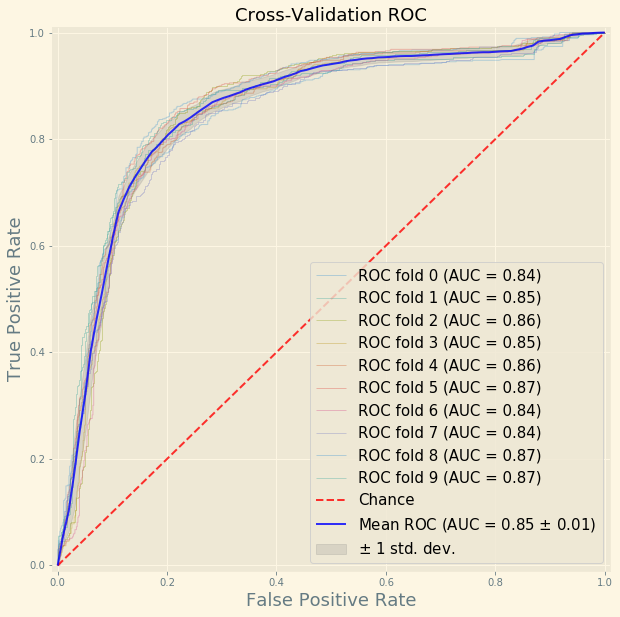

Mean AUC score: 0.8547611009621782


In [150]:
roc_curve_kfold_cross_validation(X_train=X_train_res, y_train=y_train_res, n_splits=10)

### Cross-validation (Kfold) applied to the undersampled dataset (with Nearmiss)

In [113]:
# Build the k-fold cross-validator
k_fold_split = 10
kfold = KFold(n_splits=k_fold_split, random_state=2019, shuffle=True)
#result = cross_val_score(gnb, X, Y, cv=kfold, scoring='accuracy')
result = cross_val_score(gnb2, X_train_miss, y_train_miss, cv=kfold, scoring='accuracy')

print('--------------------------------------------------------------------------')
print('All the accuracy results:')
print('--------------------------------------------------------------------------')
print(result, '\n')

print('--------------------------------------------------------------------------')
print('Average of all the accuracy results:')
print('--------------------------------------------------------------------------')
print(round(result.mean(), 4), '\n')

print('--------------------------------------------------------------------------')
print('Conclusion: the average of the accuracy changed after applying Kfold:')
print('--------------------------------------------------------------------------')
print('from:')
print(round(metrics.accuracy_score(y_test, y_pred), 5))
print('to:')
print(round(result.mean(), 5))
print('This is because we only use: {0:0.2f}% of our dataset to train the model!'.format(((k_fold_split-1)/k_fold_split)*100))

--------------------------------------------------------------------------
All the accuracy results:
--------------------------------------------------------------------------
[0.54104478 0.51492537 0.48880597 0.52985075 0.55223881 0.52238806
 0.52985075 0.53731343 0.56343284 0.55970149] 

--------------------------------------------------------------------------
Average of all the accuracy results:
--------------------------------------------------------------------------
0.534 

--------------------------------------------------------------------------
Conclusion: the average of the accuracy changed after applying Kfold:
--------------------------------------------------------------------------
from:
0.75182
to:
0.53396
This is because we only use: 90.00% of our dataset to train the model!


In [158]:
# Build the k-fold cross-validator
k_fold_split = 10
kfold = KFold(n_splits=k_fold_split, random_state=2019, shuffle=True)
#result = cross_val_score(gnb, X, Y, cv=kfold, scoring='accuracy')
# note: only a single metric is permitted for parameter 'scoring'
# for all parameters for scoring, see source:https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
result_f1_weighted = cross_val_score(gnb2, X_train_miss, y_train_miss, cv=kfold, scoring='f1_weighted')
print('--------------------------------------------------------------------------')
print('All the weighted f1 results:')
print('--------------------------------------------------------------------------')
print(result_f1_weighted, '\n')

print('--------------------------------------------------------------------------')
print('Average of all the weighted f1 results:')
print('--------------------------------------------------------------------------')
print(round(result_f1_weighted.mean(), 4), '\n')

--------------------------------------------------------------------------
All the weighted f1 results:
--------------------------------------------------------------------------
[0.40907945 0.40868629 0.35816167 0.40695469 0.42506171 0.40089029
 0.39643955 0.41835082 0.43153697 0.43363367] 

--------------------------------------------------------------------------
Average of all the weighted f1 results:
--------------------------------------------------------------------------
0.4089 



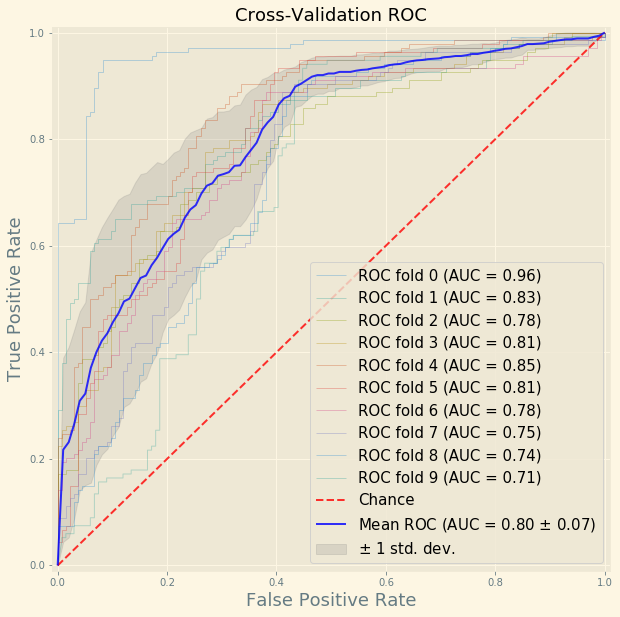

Mean AUC score: 0.8007085783205186


In [153]:
roc_curve_kfold_cross_validation(X_train=X_train_miss, y_train=y_train_miss, n_splits=10, classifier=GaussianNB())

<a id = "801"> <h2> Pipeline 2 </h2> </a>
___

In [15]:
# read csv file to a pandas dataframe
df_pipeline2 = pd.read_csv("pipeline_2.csv")

> Show all features and target in dataframe

In [16]:
# show all columns in dataset
list(df_pipeline2.columns)[:]

['TrafficType_15',
 'Month_Nov',
 'Administrative_Duration_mm_yj_stdev',
 'VisitorType_New_Visitor',
 'Informational_mm_yj_stdev',
 'TrafficType_2',
 'TrafficType_3',
 'ProductRelated_mm_yj_stdev',
 'PageValues_mm_yj_stdev',
 'Month_May',
 'TrafficType_13',
 'OperatingSystems_3',
 'TrafficType_1',
 'add_exit_bounce_rates_mm_yj_stdev',
 'Month_Mar',
 'TrafficType_18',
 'TrafficType_8',
 'SpecialDay_0.8',
 'Month_Feb',
 'TrafficType_12',
 'Browser_12',
 'Revenue']

> Declare Features and Target

In [17]:
# Define Features and Target variables
X = df_pipeline2.iloc[:, :-1] # Features is all columns in the dataframe except the last column
Y = df_pipeline2.iloc[:, -1] # Target is the last column in the dataframe: 'Revenue'

In [18]:
# Split dataset into training set and test set 
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=2019) 

# Create a Gaussian Classifier
gnb = GaussianNB()

# Train the model using the training sets
gnb.fit(X_train, y_train)

print('Before OverSampling, the shape of train_X: {}'.format(X_train.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape)) 
  
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

# Predict the response for test dataset
y_pred = gnb.predict(X_test)

# print classification report 
print(classification_report(y_test, y_pred))

Before OverSampling, the shape of train_X: (8631, 21)
After OverSampling, the shape of train_y: (8631,) 

Before OverSampling, counts of label '1': 1340
Before OverSampling, counts of label '0': 7291
              precision    recall  f1-score   support

           0       0.98      0.06      0.11      3131
           1       0.16      0.99      0.28       568

    accuracy                           0.20      3699
   macro avg       0.57      0.53      0.19      3699
weighted avg       0.85      0.20      0.13      3699



In [19]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy Naive Bayes, pipeline 1:", metrics.accuracy_score(y_test, y_pred).round(4))

Accuracy Naive Bayes, pipeline 1: 0.2011


<b> 1.1 Synthetic Minority Oversampling Technique (SMOTE)

We oversample the dataset, because the classes within our target variable 'Revenue' are imbalanced:
* class 0: 84.53%
* class 1: 15.47%

Fore more information, click on detailed information from Prof. Jie Tao [link](https://github.com/DrJieTao/ba545-docs/blob/master/competition2/handling_imbalanced_data_part2.ipynb)

In [20]:
sm = SMOTE(random_state = 2019) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (14582, 21)
After OverSampling, the shape of train_y: (14582,) 

After OverSampling, counts of label '1': 7291
After OverSampling, counts of label '0': 7291


/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The SMOTE Algorithm has oversampled the instances in the minority class and made it equal to majority class:
* Both classes (0 & 1) now have 7291 instances, the dataset is balanced.
* Class 1 increased from 1340 instances to 7291 instances, an increase of 5951 instances of class 1.

In [21]:
gnb1 = GaussianNB()
gnb1.fit(X_train_res, y_train_res)
y_pred = gnb1.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.05      0.10      3131
           1       0.16      0.99      0.28       568

    accuracy                           0.20      3699
   macro avg       0.57      0.52      0.19      3699
weighted avg       0.85      0.20      0.13      3699



In [22]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy Naive Bayes, pipeline 2:", metrics.accuracy_score(y_test, y_pred).round(4))

Accuracy Naive Bayes, pipeline 2: 0.199


<b> 1.2 NearMiss Under-Sampling Technique

In [23]:
# apply near miss 
nr = NearMiss(random_state=123) 
  
X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train) 
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape)) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

After Undersampling, the shape of train_X: (2680, 21)
After Undersampling, the shape of train_y: (2680,) 

After Undersampling, counts of label '1': 1340
After Undersampling, counts of label '0': 1340


/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The NearMiss Algorithm has undersampled the instances in the majority class and made it equal to minority class:
* Both classes (0 & 1) now have 1340 instances, the dataset is balanced.
* Class 0 decreased from 7291 instances to 1340 instances, a decrease of 5951 instances of class 0.

In [24]:
# train the model on train set 
gnb2 = GaussianNB()
gnb2.fit(X_train_miss, y_train_miss) 
y_pred = gnb2.predict(X_test) 

# print classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      3131
           1       0.10      0.08      0.08       568

    accuracy                           0.75      3699
   macro avg       0.47      0.47      0.47      3699
weighted avg       0.72      0.75      0.74      3699



<b> Cross Validation Using KFold </b>
<br> For more information on the topic, please click the following [link](https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/).
<br> The details of the package are noted [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

### Applied to the oversampled dataset (with SMOTE)

In [25]:
# Build the k-fold cross-validator
k_fold_split = 10
kfold = KFold(n_splits=k_fold_split, random_state=2019, shuffle=True)
#result = cross_val_score(gnb, X, Y, cv=kfold, scoring='accuracy')
result = cross_val_score(gnb, X_train_res, y_train_res, cv=kfold, scoring='accuracy')

print('--------------------------------------------------------------------------')
print('All the accuracy results:')
print('--------------------------------------------------------------------------')
print(result, '\n')

print('--------------------------------------------------------------------------')
print('Average of all the accuracy results:')
print('--------------------------------------------------------------------------')
print(round(result.mean(), 4), '\n')

print('--------------------------------------------------------------------------')
print('Conclusion: the average of the accuracy changed after applying Kfold:')
print('--------------------------------------------------------------------------')
print('from:')
print(round(metrics.accuracy_score(y_test, y_pred), 5))
print('to:')
print(round(result.mean(), 5))
print('This is because we only use: {0:0.2f}% of our dataset to train the model!'.format(((k_fold_split-1)/k_fold_split)*100))

--------------------------------------------------------------------------
All the accuracy results:
--------------------------------------------------------------------------
[0.54009596 0.52090473 0.50960219 0.54389575 0.53703704 0.5260631
 0.52469136 0.52057613 0.53360768 0.52743484] 

--------------------------------------------------------------------------
Average of all the accuracy results:
--------------------------------------------------------------------------
0.5284 

--------------------------------------------------------------------------
Conclusion: the average of the accuracy changed after applying Kfold:
--------------------------------------------------------------------------
from:
0.74966
to:
0.52839
This is because we only use: 90.00% of our dataset to train the model!


### Applied to the undersampled dataset (with Nearmiss)

In [26]:
# Build the k-fold cross-validator
k_fold_split = 10
kfold = KFold(n_splits=k_fold_split, random_state=2019, shuffle=True)
#result = cross_val_score(gnb, X, Y, cv=kfold, scoring='accuracy')
result = cross_val_score(gnb, X_train_miss, y_train_miss, cv=kfold, scoring='accuracy')

print('--------------------------------------------------------------------------')
print('All the accuracy results:')
print('--------------------------------------------------------------------------')
print(result, '\n')

print('--------------------------------------------------------------------------')
print('Average of all the accuracy results:')
print('--------------------------------------------------------------------------')
print(round(result.mean(), 4), '\n')

print('--------------------------------------------------------------------------')
print('Conclusion: the average of the accuracy changed after applying Kfold:')
print('--------------------------------------------------------------------------')
print('from:')
print(round(metrics.accuracy_score(y_test, y_pred), 5))
print('to:')
print(round(result.mean(), 5))
print('This is because we only use: {0:0.2f}% of our dataset to train the model!'.format(((k_fold_split-1)/k_fold_split)*100))

--------------------------------------------------------------------------
All the accuracy results:
--------------------------------------------------------------------------
[0.54104478 0.52238806 0.52238806 0.53358209 0.54850746 0.52238806
 0.54104478 0.54104478 0.56716418 0.55223881] 

--------------------------------------------------------------------------
Average of all the accuracy results:
--------------------------------------------------------------------------
0.5392 

--------------------------------------------------------------------------
Conclusion: the average of the accuracy changed after applying Kfold:
--------------------------------------------------------------------------
from:
0.74966
to:
0.53918
This is because we only use: 90.00% of our dataset to train the model!


<a id = "802"> <h2> Pipeline 3 </h2> </a>
___

In [27]:
# read csv file to a pandas dataframe
df_pipeline3 = pd.read_csv("pipeline_3.csv")

> Show all features and target in dataframe

In [28]:
# show all columns in dataset
list(df_pipeline3.columns)[:]

['Administrative_yj_stdev_zscore',
 'Month_Nov',
 'VisitorType_New_Visitor',
 'TrafficType_2',
 'Month_May',
 'TrafficType_3',
 'add_exit_bounce_rates_yj_stdev_zscore',
 'TrafficType_13',
 'PageValues_yj_stdev_zscore',
 'OperatingSystems_3',
 'TrafficType_1',
 'Month_Mar',
 'TrafficType_8',
 'SpecialDay_0.8',
 'Month_Feb',
 'Month_Dec',
 'SpecialDay_0.4',
 'TrafficType_20',
 'Month_Oct',
 'Region_1',
 'Browser_12',
 'OperatingSystems_7',
 'TrafficType_16',
 'Revenue']

> Declare Features and Target

In [29]:
# Define Features and Target variables
X = df_pipeline3.iloc[:, :-1] # Features is all columns in the dataframe except the last column
Y = df_pipeline3.iloc[:, -1] # Target is the last column in the dataframe: 'Revenue'

In [30]:
# Split dataset into training set and test set 
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=2019) 

# Create a Gaussian Classifier
gnb = GaussianNB()

# Train the model using the training sets
gnb.fit(X_train, y_train)

print('Before OverSampling, the shape of train_X: {}'.format(X_train.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape)) 
  
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

# Predict the response for test dataset
y_pred = gnb.predict(X_test)

# print classification report 
print(classification_report(y_test, y_pred))

Before OverSampling, the shape of train_X: (8631, 23)
After OverSampling, the shape of train_y: (8631,) 

Before OverSampling, counts of label '1': 1340
Before OverSampling, counts of label '0': 7291
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      3131
           1       0.39      0.84      0.53       568

    accuracy                           0.77      3699
   macro avg       0.67      0.80      0.69      3699
weighted avg       0.87      0.77      0.80      3699



In [31]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy Naive Bayes, pipeline 3:", metrics.accuracy_score(y_test, y_pred).round(4))

Accuracy Naive Bayes, pipeline 3: 0.7705


<b> 1.1 Synthetic Minority Oversampling Technique (SMOTE)

We oversample the dataset, because the classes within our target variable 'Revenue' are imbalanced:
* class 0: 84.53%
* class 1: 15.47%

Fore more information, click on detailed information from Prof. Jie Tao [link](https://github.com/DrJieTao/ba545-docs/blob/master/competition2/handling_imbalanced_data_part2.ipynb)

In [32]:
sm = SMOTE(random_state = 2019) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (14582, 23)
After OverSampling, the shape of train_y: (14582,) 

After OverSampling, counts of label '1': 7291
After OverSampling, counts of label '0': 7291


/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The SMOTE Algorithm has oversampled the instances in the minority class and made it equal to majority class:
* Both classes (0 & 1) now have 7291 instances, the dataset is balanced.
* Class 1 increased from 1340 instances to 7291 instances, an increase of 5951 instances of class 1.

In [33]:
gnb1 = GaussianNB()
gnb1.fit(X_train_res, y_train_res)
y_pred = gnb1.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.52      0.67      3131
           1       0.26      0.92      0.40       568

    accuracy                           0.58      3699
   macro avg       0.62      0.72      0.54      3699
weighted avg       0.86      0.58      0.63      3699



In [34]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy Naive Bayes, pipeline 1:", metrics.accuracy_score(y_test, y_pred).round(4))

Accuracy Naive Bayes, pipeline 1: 0.5777


<b> 1.2 NearMiss Under-Sampling Technique

In [35]:
# apply near miss 
nr = NearMiss(random_state=123) 
  
X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train) 
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape)) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

After Undersampling, the shape of train_X: (2680, 23)
After Undersampling, the shape of train_y: (2680,) 

After Undersampling, counts of label '1': 1340
After Undersampling, counts of label '0': 1340


/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The NearMiss Algorithm has undersampled the instances in the majority class and made it equal to minority class:
* Both classes (0 & 1) now have 1340 instances, the dataset is balanced.
* Class 0 decreased from 7291 instances to 1340 instances, a decrease of 5951 instances of class 0.

In [36]:
# train the model on train set 
gnb2 = GaussianNB()
gnb2.fit(X_train_miss, y_train_miss) 
y_pred = gnb2.predict(X_test) 

# print classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      3131
           1       0.07      0.05      0.06       568

    accuracy                           0.76      3699
   macro avg       0.46      0.47      0.46      3699
weighted avg       0.72      0.76      0.74      3699



<b> Cross Validation Using KFold </b>
<br> For more information on the topic, please click the following [link](https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/).
<br> The details of the package are noted [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

### Applied to the oversampled dataset (with SMOTE)

In [37]:
# Build the k-fold cross-validator
k_fold_split = 10
kfold = KFold(n_splits=k_fold_split, random_state=2019, shuffle=True)
#result = cross_val_score(gnb, X, Y, cv=kfold, scoring='accuracy')
result = cross_val_score(gnb, X_train_res, y_train_res, cv=kfold, scoring='accuracy')

print('--------------------------------------------------------------------------')
print('All the accuracy results:')
print('--------------------------------------------------------------------------')
print(result, '\n')

print('--------------------------------------------------------------------------')
print('Average of all the accuracy results:')
print('--------------------------------------------------------------------------')
print(round(result.mean(), 4), '\n')

print('--------------------------------------------------------------------------')
print('Conclusion: the average of the accuracy changed after applying Kfold:')
print('--------------------------------------------------------------------------')
print('from:')
print(round(metrics.accuracy_score(y_test, y_pred), 5))
print('to:')
print(round(result.mean(), 5))
print('This is because we only use: {0:0.2f}% of our dataset to train the model!'.format(((k_fold_split-1)/k_fold_split)*100))

--------------------------------------------------------------------------
All the accuracy results:
--------------------------------------------------------------------------
[0.73337903 0.72858122 0.71399177 0.72839506 0.74279835 0.73662551
 0.7345679  0.70507545 0.72222222 0.73251029] 

--------------------------------------------------------------------------
Average of all the accuracy results:
--------------------------------------------------------------------------
0.7278 

--------------------------------------------------------------------------
Conclusion: the average of the accuracy changed after applying Kfold:
--------------------------------------------------------------------------
from:
0.76318
to:
0.72781
This is because we only use: 90.00% of our dataset to train the model!


### Applied to the undersampled dataset (with Nearmiss)

In [38]:
# Build the k-fold cross-validator
k_fold_split = 10
kfold = KFold(n_splits=k_fold_split, random_state=2019, shuffle=True)
#result = cross_val_score(gnb, X, Y, cv=kfold, scoring='accuracy')
result = cross_val_score(gnb, X_train_miss, y_train_miss, cv=kfold, scoring='accuracy')

print('--------------------------------------------------------------------------')
print('All the accuracy results:')
print('--------------------------------------------------------------------------')
print(result, '\n')

print('--------------------------------------------------------------------------')
print('Average of all the accuracy results:')
print('--------------------------------------------------------------------------')
print(round(result.mean(), 4), '\n')

print('--------------------------------------------------------------------------')
print('Conclusion: the average of the accuracy changed after applying Kfold:')
print('--------------------------------------------------------------------------')
print('from:')
print(round(metrics.accuracy_score(y_test, y_pred), 5))
print('to:')
print(round(result.mean(), 5))
print('This is because we only use: {0:0.2f}% of our dataset to train the model!'.format(((k_fold_split-1)/k_fold_split)*100))

--------------------------------------------------------------------------
All the accuracy results:
--------------------------------------------------------------------------
[0.5261194  0.5        0.46641791 0.52238806 0.54477612 0.51119403
 0.5261194  0.53358209 0.56343284 0.53358209] 

--------------------------------------------------------------------------
Average of all the accuracy results:
--------------------------------------------------------------------------
0.5228 

--------------------------------------------------------------------------
Conclusion: the average of the accuracy changed after applying Kfold:
--------------------------------------------------------------------------
from:
0.76318
to:
0.52276
This is because we only use: 90.00% of our dataset to train the model!


<a id = "810"> <h2> Results </h2> </a>
___

left align all markdown tables

In [159]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

<b> Pipeline 1 Results </b>
<br> _Note:_ tool used for Excel table to markdown conversion, namely: https://tableconvert.com/

| **Model**                           | **weighted avg F1-score** | **AUC score** |
|-----------------------------------|:-------------------------:|:-------------:|
| Basic Model                         | 0\.80                     | 0\.842        |
| Oversampled Model \(SMOTE\)         | 0\.61                     | 0\.834        |
| Undersampled Model \(Nearmiss\)     | 0\.73                     | 0\.481        |
| Cross validation Oversampled Model  | 0\.70                     | 0\.855        |
| Cross validation Undersampled Model | 0\.41                     | 0\.801        |

For pipeline 1 the best results are with training our model with oversampling using SMOTE and applying cross-validation for a more reliable result